In [79]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import pickle

# load in a bunch of potentially useful files
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

iM_to_genes = {}
k_to_iM = {}
f = open('../data/precise_1.0/iM_table.csv', 'r')
lines = f.readlines()
f.close()
k_to_iM = {line.split(',')[0] : line.split(',')[1] for line in lines[1:]}
f = open('../data/precise_1.0/gene_presence_list.csv', 'r')
lines = f.readlines()
f.close()
for line in lines[1:]:
    k = line.split(',')[1]
    iM = k_to_iM[k]
    gene = line.split(',')[2].replace('\n', '')
    if iM not in iM_to_genes:
        iM_to_genes.update({iM : []})
    iM_to_genes[iM].append(gene)

A = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0).rename(index = {int(k) : v for k, v in k_to_iM.items()})
M = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0).rename(columns = {str(k) : v for k, v in k_to_iM.items()})
centered_log_tpm = log_tpm_df.sub(log_tpm_df[['control__wt_glc__1','control__wt_glc__2']].mean(axis=1),axis=0)
all_A = M.T.dot(centered_log_tpm)

starve_metabs = pd.read_excel('../data/validation_data_sets/stationary_phase/metabolites_data.xlsx', index_col = 0)

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

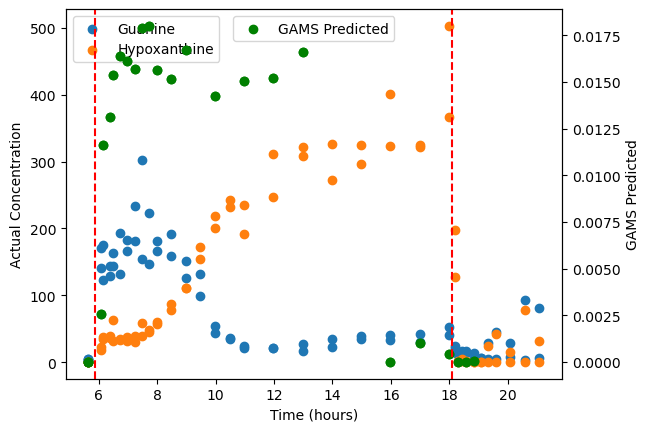

In [71]:
# plotting

# settings
case = 'Purine'
metabolites = ['Guanine', 'Hypoxanthine']
include_GAMS_predicted = True

if include_GAMS_predicted:
    iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
    run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
    GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
    GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    metab_df = inh_metab_df[inh_metab_df['iM'] == case]
    
times = 't0_1	t1_1	t2_1	t3_1	t4_1	t5_1	t6_1	t7_1	t8_1	t9_1	t10_1	t11_1	t12_1	t13_1	t14_1	t15_1	t16_1	t17_1	t18_1	t19_1	t20_1	t21_1	t22_1	t23_1	t24_1	t25_1	t26_1	t27_1	t28_1	t29_1	t30_1	t31_1	t32_1	t33_1	t34_1'
hours = '5.65	6.07	6.15	6.38	6.48	6.73	6.98	7.23	7.48	7.73	7.98	8.48	8.98	9.48	9.98	10.48	10.98	11.98	12.98	13.98	14.98	15.98	16.98	17.98	18.18	18.28	18.42	18.58	18.83	19.08	19.33	19.58	20.08	20.58	21.08'
time_to_hours = {k.split('_')[0] : float(v) for k, v in zip(times.split('\t'), hours.split('\t'))}

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for metabolite in metabolites:
    x_vals = []
    y_vals = []
    time_to_vals = {}
    for sample, val in starve_metabs.loc[metabolite][1:].items():
        tim = 't'+str(int(sample.split('__t')[1].split('_')[0]))
        x_vals.append(time_to_hours[tim])
        y_vals.append(val)
        if time_to_hours[tim] not in time_to_vals:
            time_to_vals.update({time_to_hours[tim] : []})
        time_to_vals[time_to_hours[tim]].append(val)
    ax1.scatter(x_vals, y_vals, label = metabolite)
if include_GAMS_predicted:
    x_vals = []
    y_vals = []
    for sample, _ in starve_metabs.loc[metabolite][1:].items():
        if sample[0:-3] in metab_df.index:
            tim = 't'+str(int(sample.split('__t')[1].split('_')[0]))
            x_vals.append(time_to_hours[tim])
            y_vals.append(metab_df.loc[sample[0:-3]].Val)
    ax2.scatter(x_vals, y_vals, label = 'GAMS Predicted', c = 'green')
ax1.legend()
ax2.legend()
ax1.set_ylabel('Actual Concentration')
ax2.set_ylabel('GAMS Predicted')
ax1.set_xlabel('Time (hours)')
plt.axvline(x = np.mean([5.65, 6.07]), c = 'r', ls = '--')
plt.axvline(x = np.mean([17.98, 18.18]), c = 'r', ls = '--')
plt.savefig('../figures/metabolite_conc.pdf', transparent = True)
plt.show()